In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Set up data augmentation and normalization for training and validation data
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation data

# Set up the training and validation data generators
train_generator = train_datagen.flow_from_directory(
    'cleaned_dataset/train',  # Directory containing training images
    target_size=(224, 224),  # Resize images to match ResNet50 input size
    batch_size=32,
    class_mode='categorical'  # Since we're dealing with multiple skin types
)

val_generator = val_datagen.flow_from_directory(
    'cleaned_dataset/val',  # Directory containing validation images
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 2929 images belonging to 3 classes.
Found 262 images belonging to 3 classes.


In [5]:
# Load pre-trained on ImageNet without the top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers 
base_model.trainable = False


In [7]:
# Create a new model on top 
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Dropout layer to prevent overfitting
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Dropout layer to prevent overfitting
    layers.Dense(train_generator.num_classes, activation='softmax')  # Adjust for your number of classes
])


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator
)

Epoch 1/30


C:\Users\hamad\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


92/92 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.3849 - loss: 1.4024 - val_accuracy: 0.3282 - val_loss: 1.1048
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.4520 - loss: 1.0335 - val_accuracy: 0.3855 - val_loss: 1.0983
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.4741 - loss: 1.0048 - val_accuracy: 0.3397 - val_loss: 1.1119
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.5165 - loss: 0.9719 - val_accuracy: 0.4008 - val_loss: 1.0799
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.5010 - loss: 0.9646 - val_accuracy: 0.3359 - val_loss: 1.0998
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.5304 - loss: 0.9493 - val_accuracy: 0.3931 - val_loss: 1.1000
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.5205 - loss: 0.9272 - val_accuracy: 0.3969 - val_loss: 1.0889
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.5447 - loss: 0.9260 - val_accuracy: 0.3817 - val_loss: 1.

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 831ms/step - accuracy: 0.4189 - loss: 1.1854
Validation Loss: 1.1792916059494019
Validation Accuracy: 0.4236641228199005
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step  
              precision    recall  f1-score   support

           0       0.20      0.15      0.17        71
           1       0.41      0.41      0.41       111
           2       0.32      0.38      0.35        80

    accuracy                           0.33       262
   macro avg       0.31      0.31      0.31       262
weighted avg       0.32      0.33      0.33       262



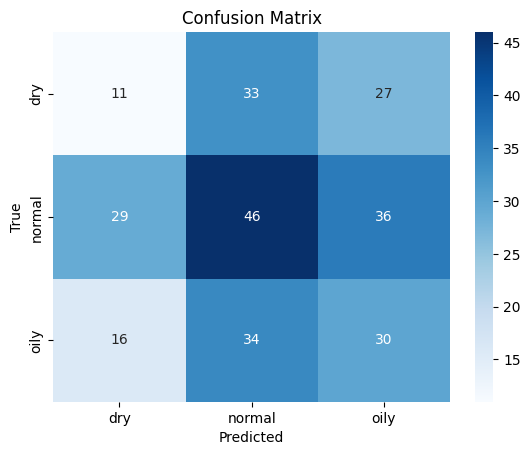

In [7]:
# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_acc}')

# Predict the labels for the validation data
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the predicted class indices
y_true = val_generator.classes  # True labels

# Classification report
print(classification_report(y_true, y_pred_classes))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [8]:
model.save("skin_model_mobilenetv2.h5")

In [8]:
# Unfreeze the last few layers of mobilenetv2 and recompile the model
base_model.trainable = True
for layer in base_model.layers[:-4]:  # Freeze all layers except the last 4
    layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Fine-tune the model
history_fine_tune = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator
)

Epoch 1/30


C:\Users\hamad\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


92/92 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.3621 - loss: 1.2994 - val_accuracy: 0.3206 - val_loss: 1.2869
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.4608 - loss: 1.0635 - val_accuracy: 0.3321 - val_loss: 1.2251
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.4953 - loss: 1.0307 - val_accuracy: 0.3282 - val_loss: 1.2184
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.5034 - loss: 0.9872 - val_accuracy: 0.3321 - val_loss: 1.2199
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.5222 - loss: 0.9590 - val_accuracy: 0.3435 - val_loss: 1.2198
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.5739 - loss: 0.9138 - val_accuracy: 0.3511 - val_loss: 1.1976
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.5621 - loss: 0.9046 - val_accuracy: 0.3359 - val_loss: 1.2045
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.5731 - loss: 0.8802 - val_accuracy: 0.3664 - val_loss: 1.

In [9]:
model.save("skin_model_mobilenetv2_finetuned.h5")

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 755ms/step - accuracy: 0.4112 - loss: 1.4635
Validation Loss: 1.5238927602767944
Validation Accuracy: 0.40458014607429504
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 927ms/step
              precision    recall  f1-score   support

           0       0.29      0.27      0.28        71
           1       0.38      0.41      0.39       111
           2       0.31      0.30      0.31        80

    accuracy                           0.34       262
   macro avg       0.33      0.32      0.32       262
weighted avg       0.33      0.34      0.33       262



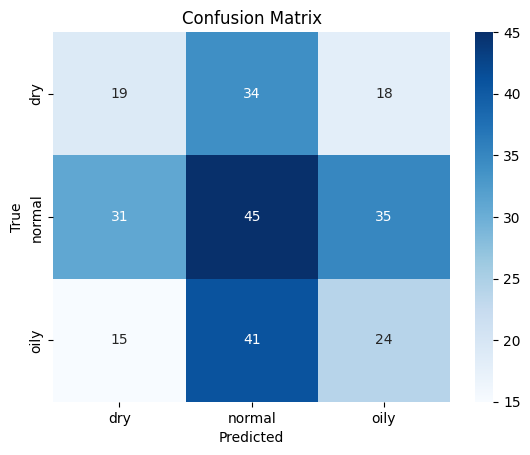

In [10]:
# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_acc}')

# Predict the labels for the validation data
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the predicted class indices
y_true = val_generator.classes  # True labels

# Classification report
print(classification_report(y_true, y_pred_classes))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [5]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('skin_model_mobilenetv2_finetuned.h5')  


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)  # Apply the same preprocessing
test_generator = test_datagen.flow_from_directory(
    'cleaned_dataset/test', 
    target_size=(224, 224), 
    batch_size=32, 
    class_mode='categorical', 
    shuffle=False)

# Evaluate model
loss, accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy*100:.2f}%')


Found 134 images belonging to 3 classes.


C:\Users\hamad\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 659ms/step - accuracy: 0.4550 - loss: 1.4158
Test Accuracy: 46.27%


In [6]:
from tensorflow.keras.preprocessing import image
class_labels = ['Dry Skin', 'Normal Skin', 'Oily Skin']

def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dims for batch processing
    img_array = img_array / 255.0  # Normalize (if done during training)
    return img_array

def predict_skin_type(img_path):
    img_array = preprocess_image(img_path)
    predictions = model.predict(img_array)  # Get probabilities for all classes
    confidence = np.max(predictions)  # Highest probability value
    predicted_class = class_labels[np.argmax(predictions)]  # Get class with highest confidence
    
    return predicted_class, confidence

img_path = 'test.jpeg'  
predicted_class, confidence = predict_skin_type(img_path)
print(f'Predicted Skin Type: {predicted_class} (Confidence: {confidence*100:.2f}%)')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Skin Type: Normal Skin (Confidence: 98.11%)


In [8]:
img_path = 'test2.jpg'
predicted_class, confidence = predict_skin_type(img_path)
print(f'Predicted Skin Type: {predicted_class} (Confidence: {confidence*100:.2f}%)')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Predicted Skin Type: Oily Skin (Confidence: 99.89%)


In [9]:
img_path = 'test3.jpg'
predicted_class, confidence = predict_skin_type(img_path)
print(f'Predicted Skin Type: {predicted_class} (Confidence: {confidence*100:.2f}%)')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Predicted Skin Type: Dry Skin (Confidence: 98.11%)


In [7]:
img_path = 'test4.jpeg'
predicted_class, confidence = predict_skin_type(img_path)
print(f'Predicted Skin Type: {predicted_class} (Confidence: {confidence*100:.2f}%)')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
Predicted Skin Type: Normal Skin (Confidence: 66.14%)
